# Notebook for training a Keras Neural Network on Betting Data
This notebook will contain the code for training a neural network with keras on the betting data using a custom loss function. The details of the features in the data are in the info.pdf file in the same repo. 

In [1]:
from keras.layers import BatchNormalization, Dense, Input, Dropout
from keras.optimizers import Nadam
from keras.models import Model
from keras import backend as K
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


The data should be in the same directory as shown here

In [2]:
!ls

1706.02275.pdf			   mjpro150_linux.zip
1707.05821.pdf			   odds_loss.hdf5
1707.06658.pdf			   output.pdf
Cracking the Coding Interview.pdf  Policy Gradient Algorithms.pdf
extract-2018-12-13.csv		   Psych.The.Movie.2017.720p.mkv
main (2).ipynb			   sutton.pdf


In [3]:
def get_data():
    data = pd.read_csv('extract-2018-12-13.csv')
    X = data.values[:, 5:-5]
    y = data.values[:, -1]
    y_full = np.zeros((X.shape[0], 8))
    for i, y_i in enumerate(y):
        if y_i == 1:
            y_full[i, 0] = 1.0
            y_full[i, 1] = 1.0
        if y_i == 2:
            y_full[i, 2] = 1.0
            y_full[i, 3] = 1.0
        if y_i == 3:
            y_full[i, 1] = 1.0
            y_full[i, 3] = 1.0
            y_full[i, 4] = 1.0
        y_full[i, 6] = X[i, 1]
        y_full[i, 7] = X[i, 2]
    return X, y_full, y
X, y, outcome = get_data()

def get_prediction_data(y_true):
    win_home_team = y_true[:, 0:1]
    win_home_or_draw = y_true[:, 1:2]
    win_away = y_true[:, 2:3]
    win_away_or_draw = y_true[:, 3:4]
    draw = y_true[:, 4:5]
    no_bet = y_true[:, 5:6]
    odds_a = y_true[:, 6:7]
    odds_b = y_true[:, 7:8]
    gain_loss_vector = np.concatenate([win_home_team * (odds_a - 1) + (1 - win_home_team) * -1,
                                      win_home_or_draw * (1/(1 -1/odds_b) - 1) + (1 - win_home_or_draw) * -1,
                                      win_away * (odds_b - 1) + (1 - win_away) * -1,
                                      win_away_or_draw * (1/(1 -1/odds_a) - 1) + (1 - win_away_or_draw) * -1,
                                      draw * (1/(1 - 1/odds_a - 1/odds_b) - 1) + (1 - draw) * -1,
                                      np.zeros_like(odds_a)], axis=1)
    no_leak_glv = np.concatenate([(odds_a - 1),
                                  (1/(1 -1/odds_b) - 1),
                                  (odds_b - 1),
                                  (1/(1 -1/odds_a) - 1),
                                  (1/(1 - 1/odds_a - 1/odds_b) - 1)], axis=1)
    new_y = np.zeros((y_true.shape[0], y_true.shape[1]-2))
    for i, glv in enumerate(gain_loss_vector):
        new_y[i, glv.argmax()] = 1.0
    return gain_loss_vector, new_y, no_leak_glv

gain_loss_vector, new_y, no_leak_glv = get_prediction_data(y)

The above code gives the X and y for the odds loss, additionally we get the no_leak_glv, what I mean by no leak is it does not contain any information about the actual outcome but just possible winnings for each outcome. 

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=15)
rfx = X.copy()
rfx1 = np.concatenate([rfx, no_leak_glv], axis=1)
rfy = new_y.copy()

rfx1, rfx1_t, rfy, rfy_t, y, y_t = train_test_split(rfx1, rfy, y)
rfx, rfx_t = train_test_split(rfx)

clf.fit(rfx1, rfy.argmax(axis=1))
rfpred_t = clf.predict(rfx1_t)
rfpred = clf.predict(rfx1)

print('With additonal features')
print(accuracy_score(rfpred, rfy.argmax(axis=1)))
print(accuracy_score(rfpred_t, rfy_t.argmax(axis=1)))

print('Feature importances : {}'.format(clf.feature_importances_))

clf.fit(rfx, rfy.argmax(axis=1))
rfpred_t = clf.predict(rfx_t)
rfpred = clf.predict(rfx)

print('\n\nWithout additonal features')
print(accuracy_score(rfpred, rfy.argmax(axis=1)))
print(accuracy_score(rfpred_t, rfy_t.argmax(axis=1)))
print('Feature importances : {}'.format(clf.feature_importances_))

With additonal features
0.9916666666666667
0.55
Feature importances : [0.04581722 0.05402328 0.05367424 0.02098776 0.04331359 0.01356037
 0.02675272 0.01591664 0.03556197 0.04427366 0.02566678 0.01541214
 0.02560674 0.02191783 0.03790197 0.02011781 0.04880423 0.03827283
 0.0423973  0.02485422 0.04881956 0.10833417 0.04872406 0.03414503
 0.05575162 0.04939226]


Without additonal features
1.0
0.275
Feature importances : [0.0401269  0.06071934 0.04621368 0.06574522 0.03394687 0.0521623
 0.05775605 0.02946841 0.05948217 0.05695543 0.04202192 0.03607767
 0.04496742 0.03636612 0.03787615 0.05063802 0.05952197 0.03580556
 0.04983352 0.04331904 0.06099624]


/media/ganesh/Generic/Anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The random forest code above serves little purpose to the training of our model. I added this for a few reasons. Firstly I do the train_test_split here. It can be done later also. Next I wanted to see if the no_leak_glv gives an improvement. Which it does for most splits. Finally if you run clf.feature_importances_ you can see the percentage importance for each feature and you can see that the additional features do have importance. 

In [5]:
def odds_loss(y_true, y_pred):
    """
    The function implements the custom loss function mentioned in info.pdf
    
    Inputs
    true : a vector of dimension batch_size, 7. A label encoded version of the output and the backp1_a and backp1_b
    pred : a vector of probabilities of dimension batch_size , 5.
    
    Returns 
    the loss value
    """
    win_home_team = y_true[:, 0:1]
    win_home_or_draw = y_true[:, 1:2]
    win_away = y_true[:, 2:3]
    win_away_or_draw = y_true[:, 3:4]
    draw = y_true[:, 4:5]
    no_bet = y_true[:, 5:6]
    odds_a = y_true[:, 6:7]
    odds_b = y_true[:, 7:8]
    gain_loss_vector = K.concatenate([win_home_team * (odds_a - 1) + (1 - win_home_team) * -1,
                                      win_home_or_draw * (1/(1 -1/odds_b) - 1) + (1 - win_home_or_draw) * -1,
                                      win_away * (odds_b - 1) + (1 - win_away) * -1,
                                      win_away_or_draw * (1/(1 -1/odds_a) - 1) + (1 - win_away_or_draw) * -1,
                                      draw * (1/(1 - 1/odds_a - 1/odds_b) - 1) + (1 - draw) * -1,
                                      K.zeros_like(odds_a)], axis=1)
    return -1 * K.mean(K.sum(gain_loss_vector * y_pred, axis=1))
 
true = K.variable(np.array([[1, 1, 0, 0, 0, 0, 2.0, 3.0]]), dtype='float32')
pred = K.variable(np.array([[0.6, 0.1, 0.2, 0.05, 0.05, 0.0]]), dtype='float32')
print(K.eval(odds_loss(true, pred)))

-0.35000002


The above is the odds loss as described in the pdf sent to me. It measures the profit or loss average over the input for a unit stake. 

In [6]:
def get_model(input_dim, output_dim, base=1000, multiplier=0.25, p=0.2):
    inputs = Input(shape=(input_dim,))
    l = BatchNormalization()(inputs)
    l = Dropout(p)(l)
    n = base
    l = Dense(n, activation='relu')(l)
    l = BatchNormalization()(l)
    l = Dropout(p)(l)
    n = int(n * multiplier)
    l = Dense(n, activation='relu')(l)
    l = BatchNormalization()(l)
    l = Dropout(p)(l)
    n = int(n * multiplier)
    l = Dense(n, activation='relu')(l)
    outputs = Dense(output_dim, activation='softmax')(l)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Nadam(1e-4), loss=odds_loss)
    return model

model = get_model(26, 6, 1000, 0.9, 0.8)
history = model.fit(rfx1, y, validation_data=(rfx1_t, y_t),
          epochs=200, batch_size=10, callbacks=[EarlyStopping(patience=100),
                                                ModelCheckpoint('odds_loss.hdf5',
                                                                save_best_only=True)])

Train on 120 samples, validate on 40 samples
Epoch 1/200
120/120 [==============================] - 1s 9ms/step - loss: 0.1712 - val_loss: 0.0897
Epoch 2/200
120/120 [==============================] - 0s 820us/step - loss: 0.0042 - val_loss: 0.0902
Epoch 3/200
120/120 [==============================] - 0s 825us/step - loss: 0.0952 - val_loss: 0.0917
Epoch 4/200
120/120 [==============================] - 0s 794us/step - loss: 0.0975 - val_loss: 0.0975
Epoch 5/200
120/120 [==============================] - 0s 860us/step - loss: 0.0803 - val_loss: 0.1031
Epoch 6/200
120/120 [==============================] - 0s 853us/step - loss: 0.1354 - val_loss: 0.1055
Epoch 7/200
120/120 [==============================] - 0s 870us/step - loss: 0.0517 - val_loss: 0.1014
Epoch 8/200
120/120 [==============================] - 0s 809us/step - loss: 0.0491 - val_loss: 0.1021
Epoch 9/200
120/120 [==============================] - 0s 790us/step - loss: 0.0632 - val_loss: 0.1015
Epoch 10/200
120/120 [========

120/120 [==============================] - 0s 1ms/step - loss: 0.0177 - val_loss: 0.0995
Epoch 80/200
120/120 [==============================] - 0s 992us/step - loss: -0.0392 - val_loss: 0.1003
Epoch 81/200
120/120 [==============================] - 0s 852us/step - loss: -0.0119 - val_loss: 0.1002
Epoch 82/200
120/120 [==============================] - 0s 866us/step - loss: -0.0021 - val_loss: 0.0985
Epoch 83/200
120/120 [==============================] - 0s 882us/step - loss: -0.0419 - val_loss: 0.0967
Epoch 84/200
120/120 [==============================] - 0s 836us/step - loss: -0.0462 - val_loss: 0.1013
Epoch 85/200
120/120 [==============================] - 0s 988us/step - loss: -0.0123 - val_loss: 0.1016
Epoch 86/200
120/120 [==============================] - 0s 875us/step - loss: 0.0276 - val_loss: 0.1008
Epoch 87/200
120/120 [==============================] - 0s 872us/step - loss: -0.0396 - val_loss: 0.1004
Epoch 88/200
120/120 [==============================] - 0s 825us/step - 

A few things to mention about the training and the model. 


*   The hyper parameters for the model such as dropout, multiplier and base were found by monitoring the validation loss. I tried to find values which made sure the training loss didn't drastically go down while the validation loss stayed the same. 
*   Next the choice of optimizer isn't that important. Adam or Nadam works best in my experience. They do a lot of things internally to make sure training is fast and generalization is decent. 
*   As for the loss which seems to be fluctuating for training that is mostly a fault with how keras shows it. It takes the mean over each batch but doesn't account for the changes in the model after each update. To see actual value you have to evaluate as in the next cell. 
*   As for P/L, the loss is the P/L value averaged over all the events. 
* the odds_loss.hdf5 file is a checkpoint of the model. After the training for later use you can run the below to load.

```
from keras.models import load_model
model = load_model('odds_loss.hdf5')
```

In [7]:
print('Training Loss : {}\nValidation Loss : {}'.format(model.evaluate(rfx1, y), model.evaluate(rfx1_t, y_t)))

40/40 [==============================] - 0s 304us/step
Training Loss : -0.0146282859146595
Validation Loss : 0.1008823573589325


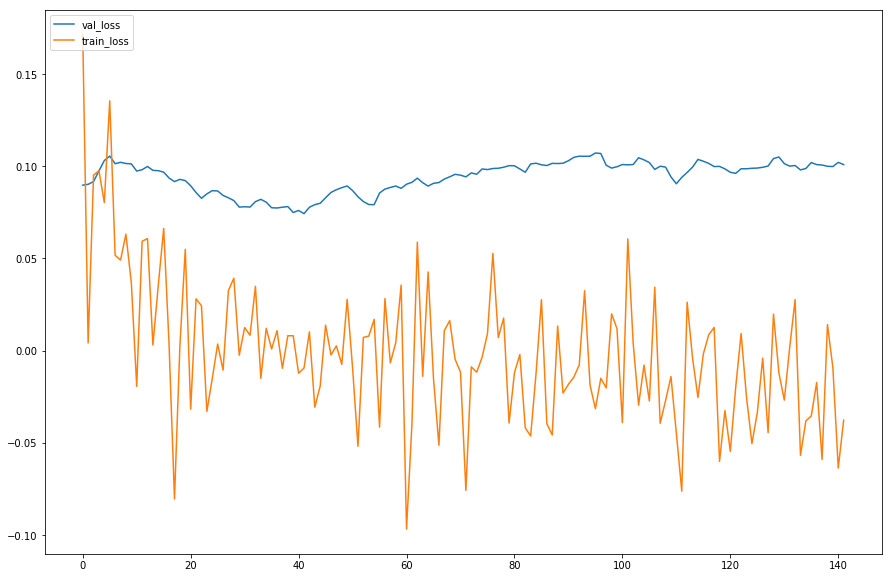

In [8]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']
plt.figure(figsize=(15,10))
plt.plot(list(range(len(val_loss))), val_loss, label='val_loss')
plt.plot(list(range(len(train_loss))), train_loss, label='train_loss')
plt.legend(loc='upper left')
plt.show()